# Overview

The goal is to recommend restaurants that the user will **like** based off that users existing reviews. I chose to use a binary (good or bad) scale in our recommendation. So in the training data I re-label all 4 and 5 star reviews as 1 and reviews with 3 stars or lower as 0.

In general, there are four scenarios that the algorithm should capture when recommending a _good_ restaurant:

1. A restaurant that has a terrible rating but for some reason the user loves it
2. A restaurant that has a terrible rating and the user also hates it
3. A restaurant that has a really good rating but for some reason the user doesn't really like it
4. A restaurant that has a really good rating and the user loves it

I want to recommend restaurants that match scenarios 1 and 4 and filter out for scenarios 2 and 3. I try to do this using the *sentiment* of a user's review, a user's *word choice*, and the *topics* in a user's corpus of reviews. 

The general idea is that we can capture the first portion of each scenario, "A restaurant that has [blank] rating", using linguistic tone and word choice. The model captures linguistic tone by creating a negative and positive word percentage feature. I use the negative and positive word categories in the Hu and Liu (2004) word dictionary to create the word counts. For each review I take a percentage of the positive and negative word counts relative to total words, identified using regular expression rules. The model captures word choice by using a TF-IDF feature matrix with an n-gram range of (2,2).

Finally, the model attempts to capture the second part of each scenario, "the user feels [blank] about it", by using topic models trained on each user's specific syntax. Specifically, we use Latent Dirichlet Allocation and Latent Semantic Indexing/Latent Semantic Analysis to create word topics. Then, I reduce each of the tfidf matrices of each review to these topic representations. Restaurants that have reviews with weightings on topics that are similiar to the weightings on the user's good reviews should have qualities that the user will find enjoyable.


For more information see:

* [A Yelp Recommendation System](https://www.cs.cornell.edu/~rahmtin/files/YelpClassProject.pdf)
* [Original LDA paper](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)
* [2013 Yelp RecSys Kaggle Competition](https://www.kaggle.com/c/yelp-recsys-2013)
* [2013 Yelp RecSys Kaggle Competition Runner Up Recommendation System](https://kaggle2.blob.core.windows.net/forum-message-attachments/9102/vsu_RecSys2013.pdf) 
* [Hu & Liu (2004)](https://www.cs.uic.edu/~liub/publications/kdd04-revSummary.pdf)

This methodology is novel in the sense that I do not rely on restaurant attributes (Price, Locaation, Type of Food, Outdoor Seating Availability, etc), but only on the text of each user's review. Although the inputs are different, the classification methods are similiar and the model should produce similiar results if text is as good of a predictor as restaurant attributes.


# Collection/Ingest/Infrastructure

We gathered raw data from the 2017 Yelp Academic dataset challenge, available at the following link:
https://www.yelp.com/dataset_challenge

The main JSON files are below: 

1. yelp_academic_dataset_business
2. yelp_academic_dataset_review
3. yelp_academic_dataset_customer

I'm using AWS S3 as WORM storage. I used wget to import all raw files into an EC2 instance and used different clean up procedures to subset the users, busineses, and reviews. After subsetting data and importing into MongoDB, I'm able to use pymongo to import data on the fly into my local machine and make sample recommendations.

# Wrangling

After the data was ingested into the Mongo database, I had to wrangle the data into the proper subsets so that we can create proper training and tests sets for the model.
The problem to solve is three fold: 

1. Filter out non restaurant reviews 
2. Find users in that subset with enough reviews to both train and test the models
3. Structure the data in a way that could be passed to the model

The Business dataset had a json dictionary for representing each business in the dataset and information about the business type, general information such as their business hours and information about how many reviews they have and the aggregate rating of the business.

The general way I filtered the reviews was to use pymongo to query the data into a list of either user ids or business ids based on a search criteria, and then loop through that list to search for other criteria for reviews or businesses with those ids. 

The Reviews dataset had a dictionary for each review, the user id of the author of that review, the business id of the business that was being reviewed, the rating for that review.

I used Pymongo with Jupyter notebook to go through the process of wrangling. Unfortunately the reviews in the reviews dataset do not have the type of business as one of their values. The Business dataset does have the category of business it is in, along with the'business_id' field, which the reviews also have. We used mongodb to query the business collection for businesses that had ‘Restaurant’ as one of it’s categories.

Then we looped through those businesses to build a list of all the business ids for those businesses. Once we had this list of business ids, we were able to use pymongo to query the to build a dataset of reviews that had a business id that was from a business that was a restaurant.

```python
rest_biz = []

for rest in biz.find({'categories':{'$eq':'Restaurants'}}):
    rest_biz.append(rest['business_id'])
       
```

The next step was to subset those reviews into a collection of reviews by users that had more than 500 restaurant reviews. Rather than try and count all the reviews per users in the data set, we queried the user collection, which has a count of total reviews by user. This helped us subset the review set again by only getting reviews for those users. 

```python

biguser = []


for obj in u.find({'review_count':{'$gt':500}}):
    biguser.append(obj['user_id'])

```
    
Now that all of the reviews ready, I create a dictionary for the overall dataset such that the keys are user ids and the entries are lists of each user's reviews. Overall, this dictionary contains 225 users, each with at least 500 restaurant reviews.

# Model Selection/Feature Engineering

I use a grid-search like methodology for each user to select a model and to select a combination of features which lead to the greatest recommendation precision. I determine whether or not to recommend a restaurant based on how the model classifies that restaurant's reviews. More specifically, I take the raw reviews for each restaurant and classify them with either a 1 or a 0. 1 implies that the user would likely consider the review to be good and 0 implies that the user would likely consider the review to be bad.

Consider a restaurant with 20 reviews. I use a combination of different features and one of the models to classify all of the reviews. If at least 14 of those reviews are classified as 1 then the algorithm says that the user will likely enjoy that restaurant. 14 arises because we set the threshold percentage of positive classifications to 70%. I selected this percentage based on extensive testing of different subsets of the test data, using the testing procedure described below.


The features that I used are:
1. Negative/Positive Percentages
2. TF-IDF with an N-Gram range of (2,2)
3. 50-topic Latent Dirichlet Allocation
4. 50-topic Latent Semantic Indexing

I test each of the models below using different combinations of the above features. I use FeatureUnion from the SKlearn package and code our own fit and transform functions for each feature. We have also included a function in our API that allows us to combine custom features or features from different machine learning packages (such as GENSIM). Below, we provide a short explanation for LSA and LDA. TF-IDF is well documented and the wikipedia article is quite good, the negative and positive percentages are simply word counts using a word dictionary soruced from an academic study.

The models that we test on are:
1. Random Forest
2. Naive Bayes
3. Linear Support Vector Machine

I chose these three models to test each users recommendations based on extensive testing of different subsets of users and restaurants. These are classic machine learning models and excellent documentation exists for them. Some links are below:

* http://scikit-learn.org/stable/modules/ensemble.html#random-forests
* http://scikit-learn.org/stable/modules/naive_bayes.html
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

The main problem is that I do not have the ability to follow up and get feedback from users after I make a recommendation. Therefore, I have constructed the following testing procedure to select the best feature and model combination for each user in making restaurant recommendations. 

# LSA

The central problem is that multiple words can have the same conceptual meaning:

![Word Concepts](lsa_concepts.png)

LSA assumes that the physical closeness of words imply the same concept. For example, the word bank when close to the words mortgage, interest rate, or loan is conceptually related to a financial institution whereas if the word bank shows up next to lures, casting, and fish probably means a stream or river bank. Specifically, LSA uses a linear algebra technique called singular value decomposition to map the initial term-document matrix into a lower dimensional representation. The expectation is that the lower dimensional representation merges together the dimensions associated with terms that have similar meanings.

For a full mathematical derivation, see:

https://en.wikipedia.org/wiki/Latent_semantic_analysis

In [1]:
#See below for a quick video demonstration of LSA

import io
import base64
from IPython.display import HTML

video = io.open('Topic_model_scheme.webm', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

# LDA

LDA models documents as mixtures over topics. A document is represented as a bag of words and we assume that each word is drawn from a particular distribution of words. We call these distribution of words a latent topic. The number of topics, **K**, is set ex-ante as a hyper parameter. Each document is represented as a percentage weight of each topic, in this way LDA reduces the dimensonality of the original bag of words. The following is an algorithm detailing how topics are generated.

# Collapsed Gibbs Sampling

1. Go through each document **D**, and randomly assign each word in **D** to one of the **K** topics.
2. For each **D**, go through each word **W** in **D**, and for each topic **T**:
    1. Compute P(**T**|**D**) = The probability of a topic given a document. This is the proportion of words in document **D** that are currently assigned to topic **T**
    2. Compute P(**W**|**T**) = The probability of a word given a topic. This is the proportion of document assignments to topic **T** over all documents that result from the word **W**. 
3. Assign **W** to a new topic. We choose the new topic by computing the probability P(**T**|**D**) x P(**W**|**T**) for each topic and then pick the topic with the highest probability. This is the probability that topic **T** generated word **W**, holding everything else constant. In this step, we're assuming that all topic assignments except for the current word are correct, and then updating the assignment of the current word using our model of how documents are generated.
4. Repeat steps 2 and 3 until we reach a rough steady state. That is, the support of the distribution of topic **T** (the underlying words in the distribution) are not changing more than some minimal threshold.


After generating the topics, we can represent each document as a weight from each topic. Recall that we already represent the document as a bag of words, so we essentially combine the word counts for words in the same latent topic when we compute topic weights. That is, we compute the topic mixtures of each document by counting the proportion of words assigned to each topic within that document.

# Testing Procedure

To get around this problem, we exploit the fact that sometimes a user review rating is also that user's restaurant rating. For a given user, if she only has one review for a restaurant then the rating for that review is also her rating for the restaurant.

I test the recommendation system by using the following test design:

**Build:**
* Let $B$ be the total set of user reviews.
* Let $R$ be the set of restaurants that the user has reviewed only once.
* Take some percentage, $p = .25$, of the set $R$ and let this set be called $R_{test}$. We use 25% as our test slice because it performed best in informal tests, in an actual production setting we should be using cross-validation.
* Next, get all the reviews **except for the user's review** for each restaurant in $R_{test}$. Call this set of reviews $K_{test}$.
* Set the remaining $1-p = .75$ percentage of the set $R$ and call this the training set of restaurants $R_{train}$. Take the subset of reviews from $B$ that correspond to these restaurants. Let this be the set of test restaurants $B_{train}$.
* Note every restaurant in $R_{train}$ and $R_{test}$ has the User's Restaurant Rating = the User's Review Rating.

**Run:**

**Note**: For each review in $B_{test}$, we have the text of the review, the restaurant to which that review refers to, and the rating of the review.

1. Transform the reviews in $B_{test}$ using some combination of the above features.

2. For each restaurant in $R_{test}$, find the total set of reviews from the Reviews database. Let this set of reviews be $K_{test}$ as above. Note that, in $K_{test}$, we have the text of each review and the restaurant to which that review refers.

3. Transform the reviews in $K_{test}$.

4. Fit the model using the transformed reviews in $R_{train}$.
5. Predict the rating of each review in $K_{test}$.
6. For each review in each restaurant, if the predicted rating of the review is good we set the prediction to 1. If it is bad, we set the prediction to 0. For each restaurant, collect the list of predicted ratings. 
7. Take the mean of each list. By our choice of coding good as 1 and bad as 0, the mean of the list is also the percentage of restaurant reviews that we think the user will like. If this percentage is greater than 70% then we classify the restaurant as a good restaurant. That is, we try to predict whether or not a user will find a review to be "good". If a user likes enough reviews for a given restaurant then we conclude that she will probably like the restaurant and therefore recommend it.
8. From the above steps, for each combination of features and model we have:
    1. A set of test restaurants.
    2. For each restaurant, a set of its reviews, the predicted rating for each of those reviews, the predicted rating of the restaurant, and the **actual** rating that the user gave to that restaurant.

9. Using this information, we calculate the following scores for each model/feature combination:
    1. Log-Loss Score:
    $$-\sum_{i=1}^{N} \frac{\text{Good}_{i}*\log{P(Good)} - \text{(1 - Good)}_{i}*\log{1 - P(Good)}}{N}$$
    
    2. Accuracy-Score:
    $$\sum_{i=1}^{N} \frac{\text{Predicted Rating}_{i} - \text{Actual Rating}_{i}}{N}$$
    
    3. Precision-Score:
    $$\frac{\text{Total True Positives}}{\text{Total True Positives + Total False Positives}}$$

Where N is the number of  restaurants. Predicted rating is the predicted restaurant rating and actual rating is the rating that the user gave to the restaurant. $P(Good_{i})$ is the probability of our algorithm assigning a good rating to the restaurant. This probability is simply the mean of the list above, we can understand the 70% threshold as "we are at least 70% confident that the user will like the restaruant given how the restaurant's reviews are classified". True positives are defined as restaurants where the user gave a good review and our classification algorithm also resulted in a good rating. False positives are defined as restaurants where the user gave a bad review but our classification algorithm gave a good review.


A log loss score heavily punishes predictions that are highly confident and wrong, so that a log loss score of 0 means that the algorithm made highly confident and accurate predictions. The negative in front of the score means that a higher log loss score is preferred to a lower one. Accuracy is simply the percentage of restaurants that the algorithm was able to correctly identify the user's preference. A higher accuracy score is better. A precision score of 1 means that our recommendation algorithm was very good at identifying good restaurants, the user's actual rating of the recommended restaurant was positive and we did not recommend any restaurants that the user did not actually like.

I chose to focus on maximizing the precision score. The accuracy score captures how well the model performed at classifying bad restaurants, but I'm not particularly concerned about this task. The log-loss score penalizes overconfidence in bad answers, but I'm only concerend about being confident in good answers. The threshold of 70% sets a lower-bound on confidence. Maximizing precision means that the model is maximizing the ability to identify restaurants that the user will _most likely_ enjoy.

# Test Results

As mentioned above, we first filtered for only users with a large amount of reviews. For each of these users, we have run 12 different combinations of features and models as outlined above. For each of these (feature, model) combinations, we have calculated the log-loss, accuracy, and precision score.

In [5]:
#Import necessary modules and functions

import matplotlib.pyplot as plt
%matplotlib inline
import json
import os
import pandas as pd

def average_results(model_df):
    model_tests = list(set(model_df['model']))
    ll_avg, acc_avg, prec_avg = [], [], []
    for model in model_tests:
        ll_avg.append(model_df[(model_df['model'] == model)]['log_loss'].mean())
        acc_avg.append(model_df[(model_df['model'] == model)]['accuracy'].mean())
        prec_avg.append(model_df[(model_df['model'] == model)]['precision'].mean())
    
    average_results_df = pd.DataFrame({'model': model_tests, 'log_loss':ll_avg,
                                  'accuracy': acc_avg, 'precision': prec_avg})
    return average_results_df

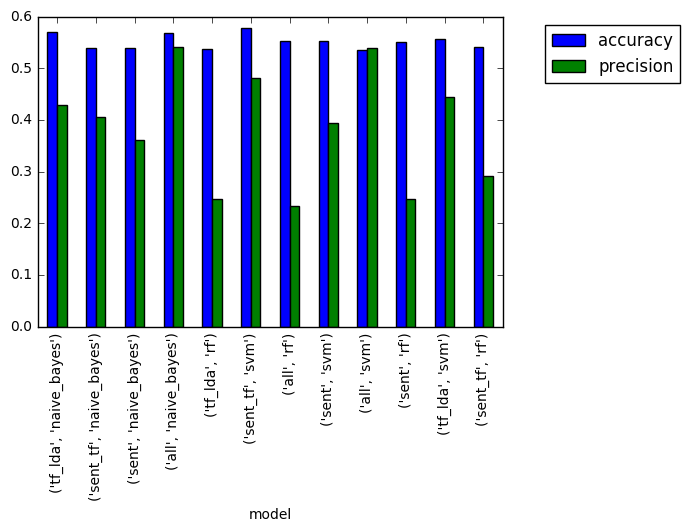

In [6]:
test_results = json.load(open("../machine_learning/test_results.json"))

model_run = []
log_loss_scores = []
accuracy_scores = []
precision_scores = []
model_tests = test_results[test_results.keys()[0]].keys()
model_results = test_results[test_results.keys()[0]].keys()

for model in model_tests:
    model_run.extend([model] * len(test_results.keys()))
    for key in test_results.keys():
        log_loss_scores.append(test_results[key][model][0])
        accuracy_scores.append(test_results[key][model][1])
        precision_scores.append(test_results[key][model][2])

model_test_results = pd.DataFrame({"model": model_run, "log_loss": log_loss_scores,
                                  "accuracy": accuracy_scores, "precision": precision_scores})

#Plot the average accuracy and precision for each model
average_results_df = average_results(model_test_results)
average_results_df.plot(x='model', y=['accuracy', 'precision']
                                      , kind='bar', legend=True)
ax = plt.subplot(111)
ax.legend(bbox_to_anchor=(1.4, 1))
plt.show()

As you can see, the average scores for each of these models across the whole sample is not that impressive. The accuracy even dominates precision in most of the cases, implying that we're better on predicting bad restaurants on average than just predicting good restaurants.

This is because different (feature, model) combinations work better for different users. If we select only the best performing (feature, model) from each user and average the results we have the following accuracy and precision averages:

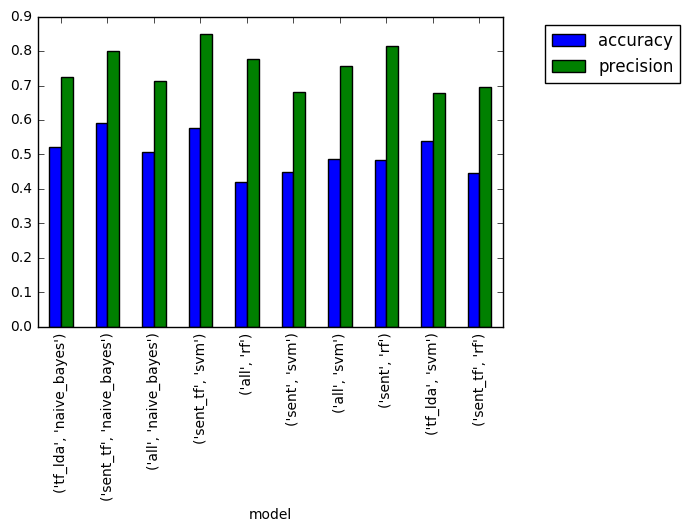

In [8]:
#Get the top result for each user
user_id = []
top_model = []
precision_scores = []
accuracy_scores = []
log_loss_scores = []

for key in test_results.keys():
    user_id.append(key)
    top_result = None
    score = 0.0
    for model in model_tests:
        if not top_result:
            top_result = model
            score = test_results[key][model][2]
        else:
            if test_results[key][model][2] > score:
                top_result = model
                prec_score = test_results[key][model][2]
                acc_score = test_results[key][model][1]
                ll_score = test_results[key][model][0]
    top_model.append(top_result)
    precision_scores.append(prec_score)
    accuracy_scores.append(acc_score)
    log_loss_scores.append(ll_score)
    
#Make a dataframe then graph the results
top_model_results = pd.DataFrame({'model': top_model, 'log_loss':log_loss_scores, 'user_id':user_id,
                                  'accuracy': accuracy_scores, 'precision': precision_scores})
top_avg_results_df = average_results(top_model_results)
top_avg_results_df.plot(x='model', y=['accuracy', 'precision']
                                      , kind='bar', legend=True)
ax = plt.subplot(111)
ax.legend(bbox_to_anchor=(1.4, 1))
plt.show()

As you can see, average precision is now much higher. It seems that on average the best performing model was the linear support vector machine with a combination of sentiment %, LSI topics, and TF-IDF (n-gram of 2) features. 

Per the below diagaram, the top three performing models are:
1. Sentiment %, TF-IDF, and LSI combined with Random Forest
2. TF_IDF, LSI, and LSA combined with a linear support vector machine
3. TF_IDF and LSI combined with Naive Bayes

Together, these three make up the 75% of all the top models selected. This suggests that in production, we can capture most of the benefits of tailoring models to users by testing only these three. Further, TF_IDF, LSI and Naive Bayes are all computationally fast and would yield great recommendation speeds.

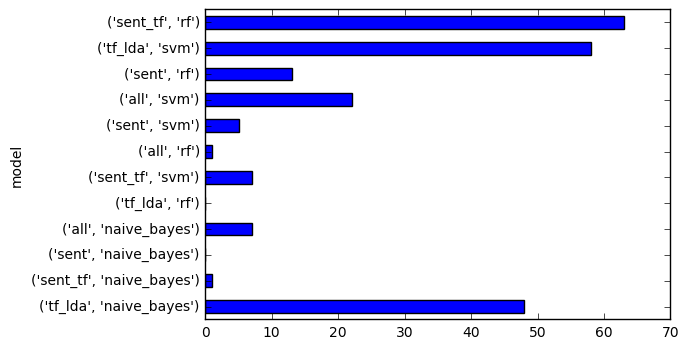

In [11]:
test_results_dict = {}
for model in model_results:
    count = len(top_model_results[top_model_results['model']==model])
    test_results_dict[model] = count
test_results_df = pd.DataFrame.from_dict(test_results_dict, orient = 'index')
test_results_df.columns = ['count']
test_results_df['model'] = test_results_df.index
test_results_df.plot(x='model', y= 'count', kind='barh', legend=False)

We also had two (feature, model) combinations that never showed up as a top choice for any of our users. We should remove them from the testing pipeline within our recommendation system.

In [12]:
all_results = set(average_results_df['model'])
top_results = set(top_avg_results_df['model'])
all_results - top_results

{u"('sent', 'naive_bayes')", u"('tf_lda', 'rf')"}

# Sample Recommendation

Please [click here](https://robertsonwang.github.io/sample_user_recommendation.html) for a Jupyter notebook that goes through an example recommendation using a sample user and her corpus reviews from the Yelp academic dataset.